References:
1. Topic Modeling with Gensim (Python) by Selva Prabhakaran|https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#2prerequisitesdownloadnltkstopwordsandspacymodelforlemmatization
2. Mallet package:http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
3. What is Topic Coherence by Devashish Deshpande: https://rare-technologies.com/what-is-topic-coherence/#what_is_topic_coherence
4. Röder, Michael, Andreas Both, and Alexander Hinneburg. "Exploring the space of topic coherence measures." In Proceedings of the eighth ACM international conference on Web search and data mining, pp. 399-408. 2015, http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf.

In [2]:
import os
import pandas as pd
from pandas.core.frame import DataFrame
import random
from random import sample
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [3]:
#import files
df=pd.read_csv('/Users/hu/Desktop/bookReview2020/genderKirkus/kirkusreviews.tsv',sep='\t')

In [4]:
df

,idx,docid,author,bookname,orig_auth,orig_title,pubdate,pubname,posted_online,kirkus_issue_date,isbn,url,review
0,40006,mdp.49015000568841,Isaac Asimov,ROBOTS AND EMPIRE,Isaac Asimov,Robots and empire,"Sept. 20th, 1985",Doubleday,"Sept. 16th, 2011","Sept. 20th, 1985",0586062009,https://www.kirkusreviews.com/book-reviews/isa...,An addition to Asimov's series of robot-detect...
1,40013,mdp.49015000750209,robert ward 4,RED BAKER,Robert Ward,Red Baker,"April 1st, 1985",Doubleday,,"April 1st, 1985",,https://www.kirkusreviews.com/book-reviews/rob...,It's certainly possible to get inside the head...
2,40014,mdp.49015000753229,tad williams 3,TAILCHASER'S SONG,Tad Williams,Tailchaser's song,"Nov. 21st, 1985",New American Library,,"Nov. 21st, 1985",,https://www.kirkusreviews.com/book-reviews/tad...,A book that may owe its existence to a certain...
3,40022,mdp.49015002778398,stephen hunter 3,THE SPANISH GAMBIT,Stephen Hunter,The Spanish gambit : a novel,"July 19th, 1985",Crown,,"July 19th, 1985",,https://www.kirkusreviews.com/book-reviews/ste...,Mock-camp spy thriller set in the Spanish Civi...
4,40023,mdp.49015002821123,robert moss 2,MOSCOW RULES,Robert Moss,Moscow rules,"Jan. 1st, 1984",Villard/Random House,,"Jan. 1st, 1984",,https://www.kirkusreviews.com/book-reviews/rob...,"This leisurely, episodic thriller eventually l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19013,9989,mdp.39015002996208,Nancy Mitford,LOVE IN A COLD CLIMATE,Nancy Mitford,Love in a cold climate,"July 8th, 1949",Random House,"April 4th, 2012","July 8th, 1949",030774082X,https://www.kirkusreviews.com/book-reviews/nan...,With less of the charm and debonair gaiety of ...
19014,9991,mdp.39015037392639,charles morgan 4,THE RIVER LINE,Charles Morgan,The River Line,"Sept. 13th, 1949",Macmillan,,"Sept. 13th, 1949",,https://www.kirkusreviews.com/book-reviews/cha...,I liked this better than anything Morgan has d...
19015,9994,mdp.39015034651441,George Orwell,NINETEEN EIGHTY-FOUR,George Orwell,"Nineteen eighty-four, a novel","June 13th, 1949","Harcourt, Brace","Nov. 2nd, 2011","June 13th, 1949",0452284236,https://www.kirkusreviews.com/book-reviews/geo...,"The Book-of-the-Month Club dual selection, wit..."
19016,9996,uc1.$b106383,Toshio Mori\nXiaojing Zhou,YOKOHAMA CALIFORNIA,Toshio Mori,"Yokohama, California. [Short stories]","March 22nd, 2015",Univ. of Washington,"Jan. 7th, 2015","March 22nd, 2015",978-0-295-99474-1,https://www.kirkusreviews.com/book-reviews/tos...,"Originally published in 1949, these 22 stories..."


In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# basic preprocessing

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


In [8]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Convert to list
data = df.review.values.tolist()
#pprint(data[:1])

In [10]:
len(data)

19018

In [11]:
data_words = list(sent_to_words(data))
#print(data_words[:1])

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])



In [14]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])



In [15]:
id2word[0]

'abandon'

In [16]:

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abandon', 1),
  ('accompany', 1),
  ('actually', 1),
  ('addition', 1),
  ('adjust', 1),
  ('also', 1),
  ('ambitious', 1),
  ('aristocratic', 1),
  ('backdrop', 1),
  ('baley', 1),
  ('begin', 1),
  ('build', 1),
  ('case', 1),
  ('center_stage', 1),
  ('century', 1),
  ('colonize', 1),
  ('convince', 1),
  ('daneel', 1),
  ('dawn', 1),
  ('death', 1),
  ('decidedly', 1),
  ('decline', 1),
  ('defeat', 1),
  ('dependant', 1),
  ('destruction', 1),
  ('disease', 1),
  ('doing', 1),
  ('drama', 1),
  ('dynamic', 1),
  ('earth', 2),
  ('effort', 1),
  ('emotion', 1),
  ('ensue', 1),
  ('establish', 1),
  ('expansion', 1),
  ('fairly', 1),
  ('flame', 1),
  ('former', 1),
  ('fulminate', 1),
  ('gladia', 1),
  ('going', 1),
  ('grapple', 1),
  ('grope', 1),
  ('halt', 1),
  ('however', 1),
  ('human', 2),
  ('impose', 1),
  ('intertwine', 1),
  ('investigate', 1),
  ('law', 1),
  ('lethal', 1),
  ('line', 1),
  ('live', 2),
  ('long', 2),
  ('long_ago', 1),
  ('mar', 1),
  ('meanwhile

In [18]:
# Building LDA Mallet Model
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# testing with topic_number=50
mallet_path = '/Users/hu/Desktop/BPO2019fall/BPOtopicModeling/mallet-2.0.8/bin/mallet'# update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=50, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(36,
  [('live', 0.04633345494345129),
   ('life', 0.042259515991730515),
   ('friend', 0.036817463212939314),
   ('home', 0.02873039036847866),
   ('move', 0.02714945883497507),
   ('job', 0.025750942478414203),
   ('good', 0.025690137419433295),
   ('find', 0.025598929830961938),
   ('work', 0.022893104706311566),
   ('neighbor', 0.018910373343062142)]),
 (38,
  [('make', 0.037521065852650325),
   ('show', 0.0221946643772457),
   ('film', 0.01888772298006296),
   ('movie', 0.017488632388947184),
   ('real', 0.016312124391872556),
   ('scene', 0.013990905911157748),
   ('tv', 0.011415307322967343),
   ('actor', 0.009920824191548222),
   ('page', 0.009030493815383636),
   ('star', 0.008235555979522401)]),
 (27,
  [('money', 0.027468330256540836),
   ('good', 0.024794703673053663),
   ('work', 0.021898274874275894),
   ('make', 0.021261697116302755),
   ('run', 0.02024317270354574),
   ('sell', 0.016137246164619007),
   ('set', 0.014322999554395569),
   ('rich', 0.014036539563307658),


In [27]:
# Show Topics
pprint(ldamallet.show_topics(50))

[(0,
  '0.024*"indian" + 0.020*"dog" + 0.020*"man" + 0.019*"animal" + '
  '0.015*"native" + 0.015*"land" + 0.014*"people" + 0.012*"wild" + '
  '0.011*"hunt" + 0.011*"bird"'),
 (1,
  '0.192*"woman" + 0.088*"man" + 0.071*"young" + 0.040*"life" + 0.026*"live" + '
  '0.021*"girl" + 0.019*"love" + 0.015*"husband" + 0.013*"story" + '
  '0.013*"female"'),
 (2,
  '0.112*"find" + 0.052*"man" + 0.033*"back" + 0.029*"dead" + 0.029*"give" + '
  '0.029*"leave" + 0.028*"year" + 0.028*"search" + 0.024*"bring" + '
  '0.022*"return"'),
 (3,
  '0.059*"story" + 0.056*"character" + 0.043*"people" + 0.040*"book" + '
  '0.038*"make" + 0.036*"feel" + 0.035*"reader" + 0.030*"life" + 0.027*"give" '
  '+ 0.022*"sense"'),
 (4,
  '0.070*"murder" + 0.043*"case" + 0.038*"mystery" + 0.020*"kill" + '
  '0.018*"suspect" + 0.014*"find" + 0.014*"crime" + 0.014*"police" + '
  '0.013*"victim" + 0.013*"death"'),
 (5,
  '0.013*"fiction" + 0.011*"half" + 0.011*"work" + 0.010*"dialogue" + '
  '0.009*"prose" + 0.009*"involve" 

Find the optimized unmber of topics

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
 # Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=100, step=10)

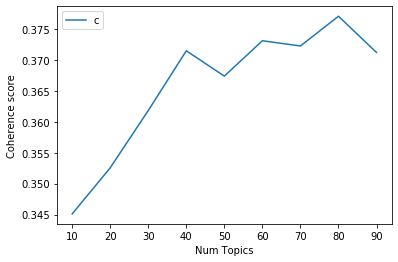

In [30]:
# Show graph
limit=100; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [35]:
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(52,
  '0.077*"find" + 0.048*"search" + 0.023*"discover" + 0.022*"travel" + '
  '0.021*"seek" + 0.020*"identity" + 0.018*"truth" + 0.017*"learn" + '
  '0.016*"meet" + 0.015*"miss"'),
 (61,
  '0.045*"brother" + 0.034*"set" + 0.031*"save" + 0.022*"lose" + '
  '0.022*"return" + 0.022*"escape" + 0.021*"turn" + 0.018*"rescue" + '
  '0.017*"stone" + 0.015*"gold"'),
 (76,
  '0.141*"mother" + 0.081*"family" + 0.045*"sister" + 0.036*"father" + '
  '0.035*"parent" + 0.032*"daughter" + 0.031*"child" + 0.016*"brother" + '
  '0.016*"home" + 0.016*"girl"'),
 (25,
  '0.063*"make" + 0.053*"city" + 0.034*"side" + 0.033*"time" + 0.025*"catch" + '
  '0.024*"heart" + 0.018*"back" + 0.018*"read" + 0.017*"end" + 0.017*"set"'),
 (41,
  '0.141*"boy" + 0.079*"girl" + 0.068*"young" + 0.032*"grow" + 0.029*"story" + '
  '0.028*"summer" + 0.023*"age" + 0.022*"adult" + 0.018*"parent" + '
  '0.017*"grace"'),
 (69,
  '0.046*"murder" + 0.030*"case" + 0.027*"lawyer" + 0.027*"kill" + '
  '0.024*"trial" + 0.023*"prison"

In [36]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.show_topics(80))

[(0,
  '0.113*"town" + 0.064*"local" + 0.027*"small" + 0.025*"set" + 0.022*"work" + '
  '0.019*"fire" + 0.017*"community" + 0.013*"character" + 0.011*"neighbor" + '
  '0.011*"run"'),
 (1,
  '0.034*"show" + 0.030*"film" + 0.028*"movie" + 0.026*"make" + 0.020*"end" + '
  '0.019*"play" + 0.016*"tv" + 0.016*"actor" + 0.015*"real" + 0.013*"career"'),
 (2,
  '0.054*"world" + 0.026*"give" + 0.023*"form" + 0.023*"future" + '
  '0.019*"present" + 0.018*"lose" + 0.018*"find" + 0.015*"sense" + '
  '0.013*"hold" + 0.013*"person"'),
 (3,
  '0.037*"feel" + 0.034*"love" + 0.026*"sense" + 0.024*"emotional" + '
  '0.021*"fear" + 0.020*"relationship" + 0.017*"experience" + 0.014*"feeling" '
  '+ 0.013*"sensitive" + 0.013*"emotion"'),
 (4,
  '0.070*"sex" + 0.048*"sexual" + 0.015*"gay" + 0.013*"homosexual" + '
  '0.011*"male" + 0.010*"scene" + 0.010*"sexually" + 0.009*"female" + '
  '0.009*"rape" + 0.008*"bed"'),
 (5,
  '0.074*"murder" + 0.055*"mystery" + 0.035*"case" + 0.025*"suspect" + '
  '0.021*"find"

In [37]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
# Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,78.0,0.2212,"human, earth, world, future, space, planet, id...",An addition to Asimov's series of robot-detect...
1,1,50.0,0.1249,"theme, fiction, dialogue, involve, narration, ...",It's certainly possible to get inside the head...
2,2,31.0,0.1069,"dog, animal, human, wild, bird, fish, tree, ca...",A book that may owe its existence to a certain...
3,3,12.0,0.1185,"secret, plan, agent, spy, plot, action, terror...",Mock-camp spy thriller set in the Spanish Civi...
4,4,12.0,0.1190,"secret, plan, agent, spy, plot, action, terror...","This leisurely, episodic thriller eventually l..."
5,5,5.0,0.0316,"murder, mystery, case, suspect, find, police, ...","Another Hercule Poirot story; setting a big ""d..."
6,6,12.0,0.1161,"secret, plan, agent, spy, plot, action, terror...",One woman's attempt to assassinate an East Ger...
7,7,64.0,0.0540,"money, business, job, sell, company, big, pay,...",Patrick returns to the scene of his first lite...
8,8,13.0,0.0872,"half, page, lot, type, funny, finally, style, ...","Best known for his zingy Fletch mysteries, Mcd..."
9,9,9.0,0.1201,"kill, plot, turn, steal, shoot, call, hire, gu...",First novel about a New York private eye and s...


In [39]:
df_dominant_topic.to_csv('dominant_topic_for_each_review.csv')